[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (comming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jul 30 07:56:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0 \
tensorflow==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/2

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [4]:
!mkdir {HOME}/images
!mkdir {HOME}/dataset

In [5]:
IMAGE_DIR_PATH = f"{HOME}/images"


### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [6]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 200


**NOTE:** We can also plot sample of our image dataset.

In [7]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

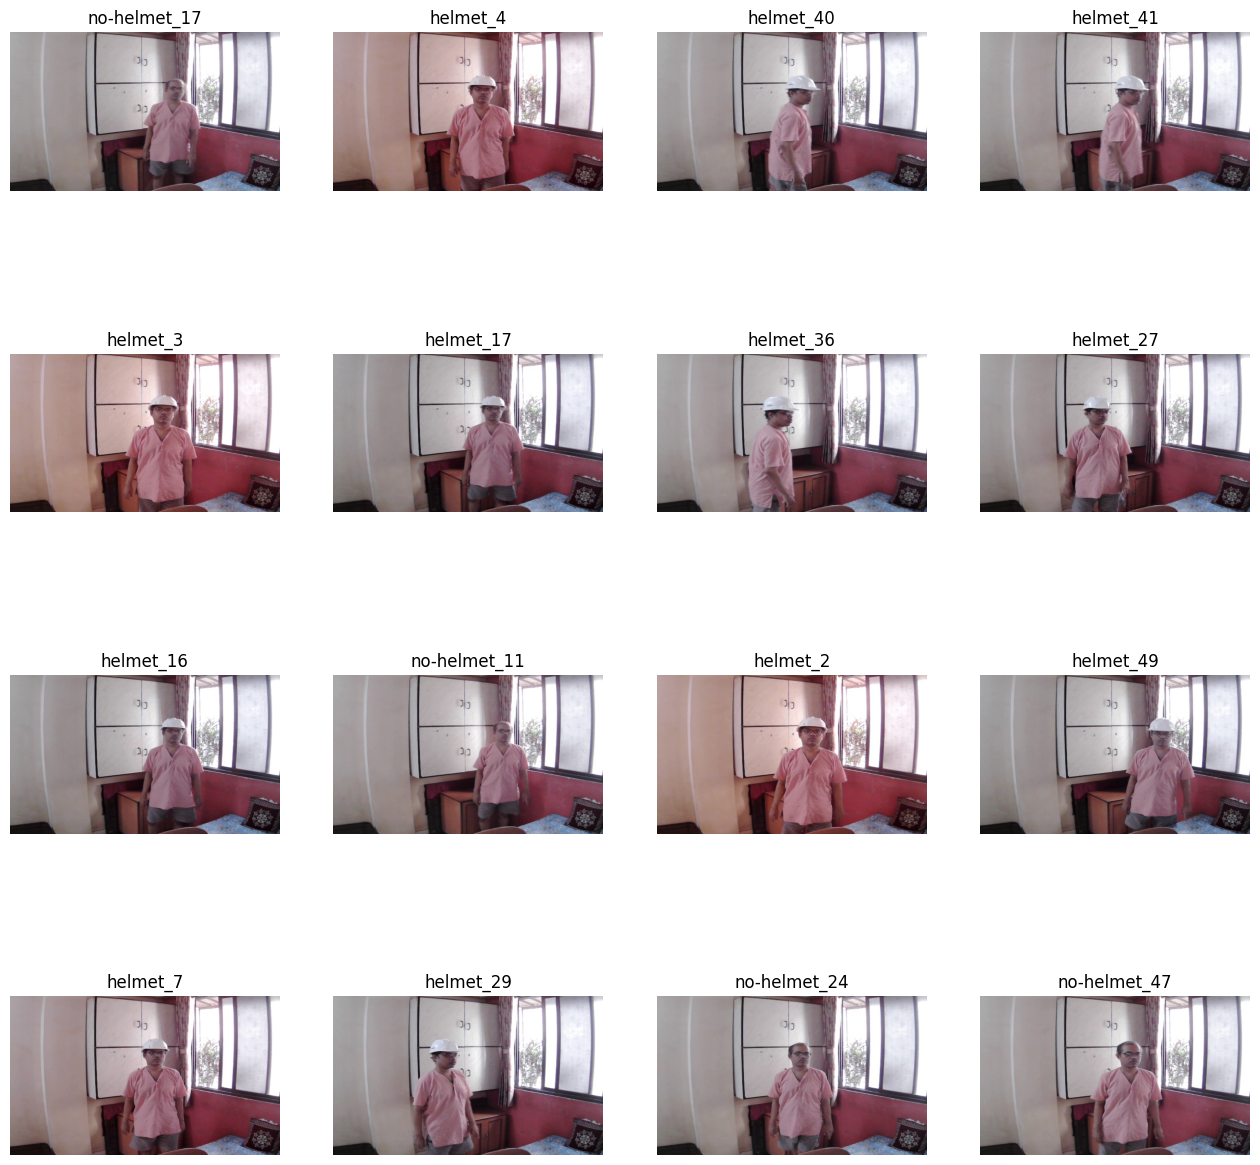

In [8]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [9]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "safety helmet": "helmet",
    "human face": "face",

})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [10]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [11]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Labeling /content/images/no-helmet_17.jpg:   0%|          | 0/100 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences bet

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [12]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [13]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

80

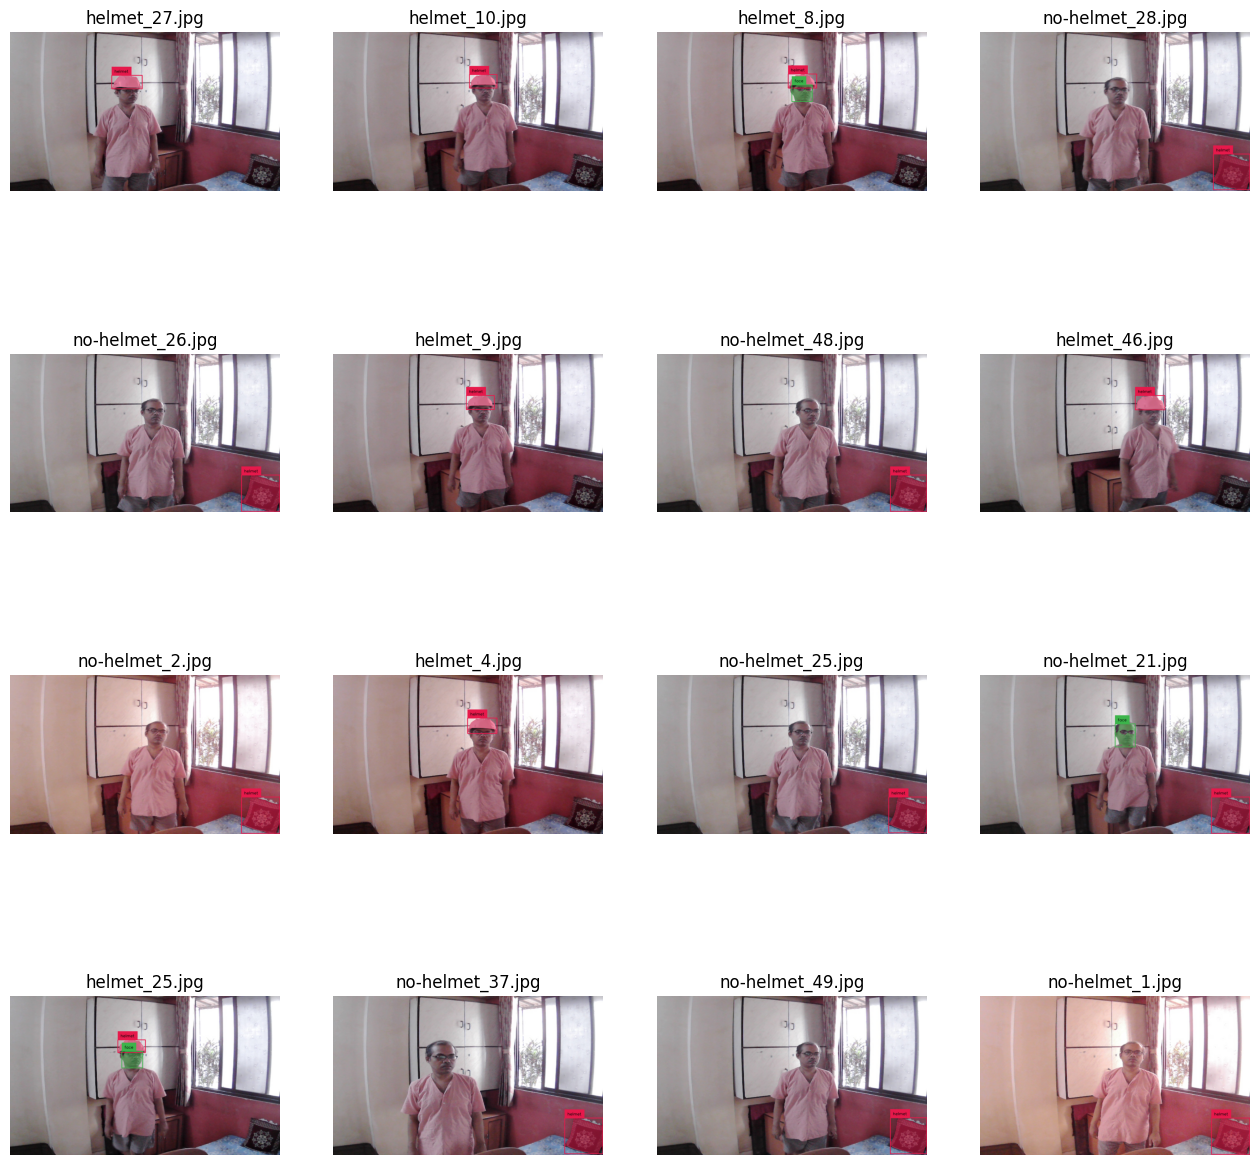

In [14]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [2]:


from autodistill_yolov8 import YOLOv8
!yolo task=detect mode=train model=yolov8s.pt data=/content/dataset/data.yaml epochs=100 imgsz=640 plots=True


[Errno 2] No such file or directory: '{HOME}'
/content
100% 6.23M/6.23M [00:00<00:00, 333MB/s]
New https://pypi.org/project/ultralytics/8.2.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=100, patience=50, batch=16, imgsz=240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_strid

In [4]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source='/content/images/helmet_2.jpg' save=True


2024-07-30 08:23:03.487001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 08:23:03.487071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 08:23:03.489267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/images/helmet_2.jpg: 160x256 1 helmet, 1 face, 87.5ms
Speed: 0.5ms preprocess, 87.5ms inference, 581.2ms postprocess per image at shape (1, 3, 256, 256)
Results saved to runs/dete